In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install idx2numpy acoustics

     |████████████████████████████████| 860kB 16.0MB/s 
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-cp37-none-any.whl size=7907 sha256=9091bab1aa6fa32ddc3bdd557466f06b0f04a46d6159e6c955f0795b9e21c964
  Stored in directory: /root/.cache/pip/wheels/7a/c1/da/284ce80a748fab898b8d1fa95468a386e7cf3b81da18511f9d
  Created wheel for acoustics: filename=acoustics-0.2.4.post0-cp37-none-any.whl size=68741 sha256=ff560c7b1710addc4ef37deae9c8af2159cfd724cba38936f0804902f68cc407
  Stored in directory: /root/.cache/pip/wheels/b6/15/f8/dcf1503edc7c990e0b0d309bf8ca5efa14f1daed5eef9ba2f9
Successfully built idx2numpy acoustics


In [ ]:
import numpy as np
import idx2numpy
import pandas as pd 
import cv2
import gzip
import os
import gc
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import scipy.io
import matplotlib.pyplot as plt
import acoustics
import datetime

# Clean Dataset

In [ ]:
directorypathtrain = "/content/drive/MyDrive/MNIST/Clean/train-images.idx3-ubyte"  #pathtotrainingimages
directorypathtest = "/content/drive/MyDrive/MNIST/Clean/t10k-images.idx3-ubyte" #pathtotestingimages

In [ ]:
def get_images(directorypath):
    imagearray = idx2numpy.convert_from_file(directorypath)
    return imagearray

In [ ]:
trainimages = get_images(directorypathtrain)
print(trainimages.shape)

(60000, 28, 28)


In [ ]:
testimages = get_images(directorypathtest)
print(testimages.shape)

(10000, 28, 28)


#Adding Noise Manually

###Motion Blur

In [ ]:
#motion blur
def motion_blur_kernel(image, degree=5, angle=15):
    # image = np.array(image)

    # This generates a matrix of motion blur kernels at any angle. The greater the degree, the higher the blur.
    M = cv2.getRotationMatrix2D((degree / 2, degree / 2), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))

    motion_blur_kernel = motion_blur_kernel / degree
    blurred = cv2.filter2D(image, -1, motion_blur_kernel)

    # convert to uint8
    cv2.normalize(blurred, blurred, 0, 255, cv2.NORM_MINMAX)
    blurred = np.array(blurred, dtype=np.uint8)
    
    return blurred

###AWGN

In [ ]:
def add_awgn_noise(image, snr=9.5):
    # Generate the noise as you did
    noise = acoustics.generator.white(image.size).reshape(*image.shape)
    # For the record I think np.random.random does exactly the same thing

    # work out the current SNR
    current_snr = np.mean(image) / np.std(noise)

    # scale the noise by the snr ratios (smaller noise <=> larger snr)
    noise *= (current_snr / snr)

    # return the new signal with noise
    return image + noise

###Reduced Contrast

In [ ]:
def reduce_contrast(image, awgnsnr=12, factor=0.5):
  image = image*factor
  image = add_awgn_noise(image, 12)
  return image

##Creating Separate Datasets for Each Type of Noise

In [ ]:
def datasetformation(image_array, SNR=12, angle=15, degree=5, factor=0.5, training=True):
  
  iter = 0
  if training:
    iter = 60000
  else:
    iter = 10000

  awgn_data = np.zeros((iter,28,28))
  motion_blur_data = np.zeros((iter,28,28))
  reduced_contrast_data = np.zeros((iter,28,28))

  for num in tqdm(range(iter)):
    image = image_array[num]
    awgn_image = add_awgn_noise(image, snr=9.5)
    motion_blur_image = motion_blur_kernel(image, degree=5, angle=15)
    reduced_contrast_image = reduce_contrast(image, awgnsnr=12, factor=0.5)
    awgn_data[num] = awgn_image
    motion_blur_data[num] = motion_blur_image
    reduced_contrast_data[num] = reduced_contrast_image
  
  if training:
    np.save("/content/drive/MyDrive/MNIST/Clean/awgn_train.npy", awgn_data)
    np.save("/content/drive/MyDrive/MNIST/Clean/motion_blur_train.npy", motion_blur_data)
    np.save("/content/drive/MyDrive/MNIST/Clean/reduced_contrast_train.npy", reduced_contrast_data)

  else:
    np.save("/content/drive/MyDrive/MNIST/Clean/awgn_test.npy", awgn_data)
    np.save("/content/drive/MyDrive/MNIST/Clean/motion_blur_test.npy", motion_blur_data)
    np.save("/content/drive/MyDrive/MNIST/Clean/reduced_contrast_test.npy", reduced_contrast_data)

In [ ]:
datasetformation(trainimages, training=True)
datasetformation(testimages, training=False)

In [ ]:
#form the vectorized inputs and save
awgnpath = "/content/drive/MyDrive/MNIST/Clean/awgn_test.npy"
motionblurpath = "/content/drive/MyDrive/MNIST/Clean/motion_blur_test.npy"
reducedcontrastpath = "/content/drive/MyDrive/MNIST/Clean/reduced_contrast_test.npy"
groundtruthpath = "/content/drive/MyDrive/MNIST/Clean/t10k-images.idx3-ubyte"
groundtruthimages = idx2numpy.convert_from_file(groundtruthpath)
awgnimages = np.load(awgnpath)
motionblurimages = np.load(motionblurpath)
reducedcontrastimages = np.load(reducedcontrastpath)

gdvector = np.zeros((10000,784))
awgnvector = np.zeros((10000,784))
mbvector = np.zeros((10000,784))
rcvector = np.zeros((10000,784))

for i in range(10000):
  awgnsingle = np.reshape(awgnimages[i, : ,:], (784))
  awgnvector[i] = awgnsingle
  mbsingle = np.reshape(motionblurimages[i, : ,:], (784))
  mbvector[i] = mbsingle
  rcsingle = np.reshape(reducedcontrastimages[i, : ,:], (784))
  rcvector[i] = rcsingle
  gdsingle = np.reshape(groundtruthimages[i, : ,:], (784))
  gdvector[i] = gdsingle

  assert gdvector.shape == (10000, 784)

np.save("/content/drive/MyDrive/MNIST/Clean/awgn_test_vectorized.npy", awgnvector)
np.save("/content/drive/MyDrive/MNIST/Clean/motion_blur_test_vectorized.npy", mbvector)
np.save("/content/drive/MyDrive/MNIST/Clean/reduced_contrast_test_vectorized.npy", rcvector)
idx2numpy.convert_to_file("/content/drive/MyDrive/MNIST/Clean/t10k-images_vectorized.idx3-ubyte", gdvector)

# Noisy Dataset

In [ ]:
# awgn_path = "/content/drive/MyDrive/MNIST/Noise/AWGN/mnist-with-awgn.mat"
# motionblur_path = "/content/drive/MyDrive/MNIST/Noise/MotionBlur/mnist-with-motion-blur.mat"
# reduced_path = "/content/drive/MyDrive/MNIST/Noise/ReducedContrast/mnist-with-reduced-contrast-and-awgn.mat"
# awgnmat = scipy.io.loadmat('/content/drive/MyDrive/MNIST/Noise/AWGN/mnist-with-awgn.mat')
# trainimage = (awgnmat['train_x'][1])
# print(trainimage.shape)
# trainimage = np.reshape(trainimage, (28, 28))
# print(trainimage.shape)

#Dataset Class

In [ ]:
class NoisyMNISTDataset(Dataset):
  def __init__(self, noisetype, noisedir, rootdir, vectorized = False):
    self.noisetype = noisetype
    self.noisedir = noisedir
    self.groundtruthpath = rootdir
    self.vectorized = vectorized
  
  def __len__(self):
    return idx2numpy.convert_from_file(self.groundtruthpath).shape[0]   #examples in training set

  def __getitem__(self,idx):
    
    groundtruthimage = idx2numpy.convert_from_file(self.groundtruthpath)[idx]
    noiseinputimage = np.load(self.noisedir)[idx]

    if self.vectorized:
      groundtruthvector = np.reshape(groundtruthimage, (groundtruthimage.shape[0]*groundtruthimage.shape[1],))
      noiseinputvector = np.reshape(noiseinputimage, (noiseinputimage.shape[0]*noiseinputimage.shape[1],))

      del groundtruthimage, noiseinputimage

      assert groundtruthvector.shape == (784,)
      assert noiseinputvector.shape == (784,)
      
      return (noiseinputvector, groundtruthvector)

    else:
      assert groundtruthimage.shape == (28,28)
      assert noiseinputimage.shape == (28,28)

      return (noiseinputarray, groundtrutharray)

#Dataloader

###Training Dataloader


####Vectorized

In [ ]:
awgntrain = NoisyMNISTDataset('awgn', noisedir="/content/drive/MyDrive/MNIST/Clean/awgn_train.npy", 
                              rootdir="/content/drive/MyDrive/MNIST/Clean/train-images.idx3-ubyte", vectorized=True)

motionblurtrain = NoisyMNISTDataset('motionblur', noisedir="/content/drive/MyDrive/MNIST/Clean/motion_blur_train.npy", 
                              rootdir="/content/drive/MyDrive/MNIST/Clean/train-images.idx3-ubyte", vectorized=True)

reducedcontrasttrain = NoisyMNISTDataset('reducedcontrast', noisedir="/content/drive/MyDrive/MNIST/Clean/reduced_contast_train.npy", 
                              rootdir="/content/drive/MyDrive/MNIST/Clean/train-images.idx3-ubyte", vectorized=True)

In [ ]:
# params = {"batch_size":batch_size, 
#           "shuffle":True, 
#           "num_workers":0}

In [ ]:
# awgntrainloader = DataLoader(awgntrain, **params)
# # motionblurtrainloader = DataLoader(motionblurtrain, **params)
# # reducedcontrasttrainloader = DataLoader(reducedcontrasttrain, **params)

# Vectorized Model

In [ ]:
class VectorizedDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(VectorizedDenoisingAutoencoder, self).__init__()

        #Encoder
        self.enc1 = nn.Linear(in_features=784, out_features=676)
        self.enc2 = nn.Linear(in_features=676, out_features=576) 
        self.enc3 = nn.Linear(in_features=576, out_features=512)
        self.enc4 = nn.Linear(in_features=512, out_features=400)
        self.enc5 = nn.Linear(in_features=400, out_features=256)
        self.enc6 = nn.Linear(in_features=256, out_features=128)
        self.enc7 = nn.Linear(in_features=128, out_features=64)
        self.enc8 = nn.Linear(in_features=64, out_features=32)

        #Decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=64)
        self.dec2 = nn.Linear(in_features=64, out_features=128)
        self.dec3 = nn.Linear(in_features=128, out_features=256)
        self.dec4 = nn.Linear(in_features=256, out_features=400)
        self.dec5 = nn.Linear(in_features=400, out_features=512)
        self.dec6 = nn.Linear(in_features=512, out_features=576)
        self.dec7 = nn.Linear(in_features=576, out_features=676)
        self.dec8 = nn.Linear(in_features=676, out_features=784) # Output image (28*28 = 784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.enc6(x))
        x = F.relu(self.enc7(x))
        x = F.relu(self.enc8(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        x = F.relu(self.dec6(x))
        x = F.relu(self.dec7(x))
        x = F.relu(self.dec8(x))

        return x

##Vectorized Autoencoder - 2

In [ ]:
class VectorizedDenoisingAutoencoderModified(nn.Module):
    def __init__(self):
        super(VectorizedDenoisingAutoencoderModified, self).__init__()

        #Encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=256) 
        #Decoder 
        self.dec1 = nn.Linear(in_features=256, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
    
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))

        return x

#Vectorized Autoencoder - 3

In [ ]:
class VectorizedDenoisingAutoencoderThree(nn.Module):
    def __init__(self):
        super(VectorizedDenoisingAutoencoderThree, self).__init__()

        #Encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        # self.enc2 = nn.Linear(in_features=512, out_features=256)
        # self.enc3 = nn.Linear(in_features=256, out_features=128) 

        #Decoder 
        # self.dec1 = nn.Linear(in_features=128, out_features=256)
        # self.dec2 = nn.Linear(in_features=256, out_features=512)
        self.dec3 = nn.Linear(in_features=512, out_features=784)
        # self.dec4 = nn.Linear(in_features=256, out_features=400)
        # self.dec5 = nn.Linear(in_features=400, out_features=512)
        # self.dec6 = nn.Linear(in_features=512, out_features=576)
        # self.dec7 = nn.Linear(in_features=576, out_features=676)
        # self.dec8 = nn.Linear(in_features=676, out_features=784) # Output image (28*28 = 784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        # x = F.relu(self.enc2(x))
        # x = F.relu(self.enc3(x))

        # x = F.relu(self.dec1(x))
        # x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))

        return x

####AWGN Model

In [ ]:
# awgnmodel = VectorizedDenoisingAutoencoderModified()

####MotionBlur Model

In [ ]:
# motionblurmodel = VectorizedDenoisingAutoencoderModified()

####ReducedContrastModel

In [ ]:
reducedcontrastmodel = VectorizedDenoisingAutoencoderModified()

####Criterion, Optimizer and Configs

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(reducedcontrastmodel.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

num_epochs = 100
dropout = 0.3

In [ ]:
awgnpath = "/content/drive/MyDrive/MNIST/Clean/awgn_train_vectorized.npy"
motionblurpath = "/content/drive/MyDrive/MNIST/Clean/motion_blur_train_vectorized.npy"
reducedcontrastpath = "/content/drive/MyDrive/MNIST/Clean/reduced_contrast_train_vectorized.npy"
groundtruthpath = "/content/drive/MyDrive/MNIST/Clean/train-images_vectorized.idx3-ubyte"

In [ ]:
# awgnpathval = "/content/drive/MyDrive/MNIST/Clean/awgn_test_vectorized.npy"
# mbpathval = "/content/drive/MyDrive/MNIST/Clean/motion_blur_test_vectorized.npy"
# rcpathval = "/content/drive/MyDrive/MNIST/Clean/reduced_contrast_test_vectorized.npy"
# gtpathval = "/content/drive/MyDrive/MNIST/Clean/t10k-images_vectorized.idx3-ubyte"

In [ ]:
noiseinputpath = reducedcontrastpath

In [ ]:
groundtruthvectors = idx2numpy.convert_from_file(groundtruthpath)
noiseinputvectors = np.load(noiseinputpath)

# groundtruthvectorsval = torch.from_numpy(idx2numpy.convert_from_file(gtpathval).astype(np.float32))
# noiseinputvectorsval = torch.from_numpy(np.load(noiseinputpathval).astype(np.float32))

In [ ]:
# print(noiseinputvectorsval[10].shape)

In [ ]:
batch_size = 64 #main control of batch size is here

#Training

In [ ]:
#training loop
reducedcontrastmodel.train()

for epoch in tqdm(range(num_epochs)):
    cumulative_loss = 0.0
    # epoch_loss = 0.0    
    batchstart = 0
    batchend = batchstart + batch_size
    numbatches = 0
    for b in range(int(60000/batch_size)+1):              #60000/64 = 938
        groundtruth = torch.from_numpy(groundtruthvectors[batchstart:batchend, :].astype(np.float32))   #(32,784)
        inputs = torch.from_numpy(noiseinputvectors[batchstart:batchend, :].astype(np.float32))

        model_output = reducedcontrastmodel(inputs)
        loss = criterion(model_output, groundtruth)
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
        if numbatches%300 == 0 and numbatches!=0:     
            print (numbatches, end=' ')
            print('Loss: ' , cumulative_loss)
            print('-----------------------------------')
            with open('/content/drive/MyDrive/MNIST/Models/reducedcontrastvectorizedmodifiedadam', 'at') as file :       
                now = datetime.datetime.now()
                current_time = now.strftime("%H:%M:%S")
                file.write("Epoch: {}, Batch: {}, Loss: {}, Time: {}\n".format(epoch, loss.item(), cumulative_loss, current_time))    
        numbatches += 1
        batchstart = batchend
        batchend = batchstart + batch_size
        # gc.collect()

    print("Epoch Loss: ", cumulative_loss/60000)

    # val_output = awgnmodel(noiseinputvectorsval[10].unsqueeze(0))
    # val_output = val_output.detach().numpy()

    # my_dpi = 40
    # fig = plt.figure(figsize=(28, 28), dpi=my_dpi)

    # ax1 = fig.add_subplot(1, 2, 1)
    # ax1.imshow(np.reshape(noiseinputvectorsval[10], (28,28)), cmap='gray')

    # ax2 = fig.add_subplot(1, 2, 2)
    # ax2.imshow(np.reshape(val_output, (28,28)), cmap='gray')

    if epoch%10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': reducedcontrastmodel.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 100
            }, '/content/drive/MyDrive/MNIST/Models/reducedcontrastvectorizedmodifiedadam.pt')




  0%|          | 0/100 [00:00<?, ?it/s]

300 Loss:  2186722.0258789062
-----------------------------------
600 Loss:  4372692.1005859375
-----------------------------------
900 Loss:  6520376.0830078125
-----------------------------------
Epoch Loss:  113.07944658203125





  1%|          | 1/100 [00:15<24:56, 15.12s/it]

300 Loss:  2186722.0258789062
-----------------------------------
600 Loss:  4372692.1005859375
-----------------------------------
900 Loss:  6520376.0830078125
-----------------------------------





  2%|▏         | 2/100 [00:28<24:04, 14.74s/it]

Epoch Loss:  113.07944658203125
300 Loss:  2186722.0258789062
-----------------------------------
600 Loss:  4372692.1005859375
-----------------------------------
900 Loss:  6520376.0830078125
-----------------------------------





  3%|▎         | 3/100 [00:42<23:24, 14.48s/it]

Epoch Loss:  113.07944658203125
300 Loss:  2186722.0258789062
-----------------------------------
600 Loss:  4372692.1005859375
-----------------------------------
900 Loss:  6520376.0830078125
-----------------------------------





  4%|▍         | 4/100 [00:56<22:47, 14.24s/it]

Epoch Loss:  113.07944658203125
300 Loss:  2186722.0258789062
-----------------------------------
600 Loss:  4372692.1005859375
-----------------------------------
900 Loss:  6520376.0830078125
-----------------------------------





  5%|▌         | 5/100 [01:10<22:18, 14.09s/it]

Epoch Loss:  113.07944658203125
300 Loss:  2186722.0258789062
-----------------------------------
600 Loss:  4372692.1005859375
-----------------------------------
900 Loss:  6520376.0830078125
-----------------------------------





  6%|▌         | 6/100 [01:24<21:54, 13.98s/it]

Epoch Loss:  113.07944658203125
300 Loss:  2186722.0258789062
-----------------------------------


KeyboardInterrupt: ignored

In [ ]:
savepath = "/content/drive/MyDrive/MNIST/Models/awgnmodelval" + str(10) + ".jpg"

fig.savefig(savepath, dpi=40, bbox_inches='tight')

##Validation

###Vectorized Models

In [ ]:
awgnpath = "/content/drive/MyDrive/MNIST/Clean/awgn_test_vectorized.npy"
mbpath = "/content/drive/MyDrive/MNIST/Clean/motion_blur_test_vectorized.npy"
rcpath = "/content/drive/MyDrive/MNIST/Clean/reduced_contrast_test_vectorized.npy"
gtpath = "/content/drive/MyDrive/MNIST/Clean/t10k-images_vectorized.idx3-ubyte"

awgnmodelpath = "/content/drive/MyDrive/MNIST/Models/awgnvectorizedmodified.pt"
mbmodelpath = "/content/drive/MyDrive/MNIST/Models/motionblurvectorizedmodified.pt"
rcmodelpath = "/content/drive/MyDrive/MNIST/Models/reducedcontrastvectorizedmodified.pt"


awgntest = torch.from_numpy(np.load(awgnpath).astype(np.float32))
mbtest = torch.from_numpy(np.load(mbpath).astype(np.float32))
rctest = torch.from_numpy(np.load(rcpath).astype(np.float32))
gt = torch.from_numpy(idx2numpy.convert_from_file(gtpath).astype(np.float32))

awgnmodel = VectorizedDenoisingAutoencoderModified()
# optimizer = torch.optim.Adam(awgnmodel.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.Adam(awgnmodel.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.Adam(awgnmodel.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
checkpoint = torch.load(awgnmodelpath)
awgnmodel.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
awgnmodel.eval()

mbmodel = VectorizedDenoisingAutoencoderModified()
checkpoint = torch.load(mbmodelpath)
mbmodel.load_state_dict(checkpoint['model_state_dict'])
mbmodel.eval()

rcmodel = VectorizedDenoisingAutoencoderModified()
checkpoint = torch.load(rcmodelpath)
rcmodel.load_state_dict(checkpoint['model_state_dict'])
rcmodel.eval()

awgnoutput = awgnmodel(awgntest)
mboutput = mbmodel(mbtest)
rcoutput = rcmodel(rctest)

awgncriterion = nn.MSELoss()
mbcriterion = nn.MSELoss()
rccriterion = nn.MSELoss()

awgnloss = awgncriterion(awgnoutput, gt)
mbloss = mbcriterion(mboutput, gt)
rcloss = rccriterion(rcoutput, gt)

awgnoutput = awgnoutput.detach().numpy()
mboutput = mboutput.detach().numpy()
rcoutput = rcoutput.detach().numpy()

print("AWGN Testing Loss: ", awgnloss.item()/64)
print("Total Motion Blur Testing Loss: ", mbloss.item()/64)
print("Total Reduced Contrast Testing Loss: ", rcloss.item()/64)

NameError: ignored

#Plotting

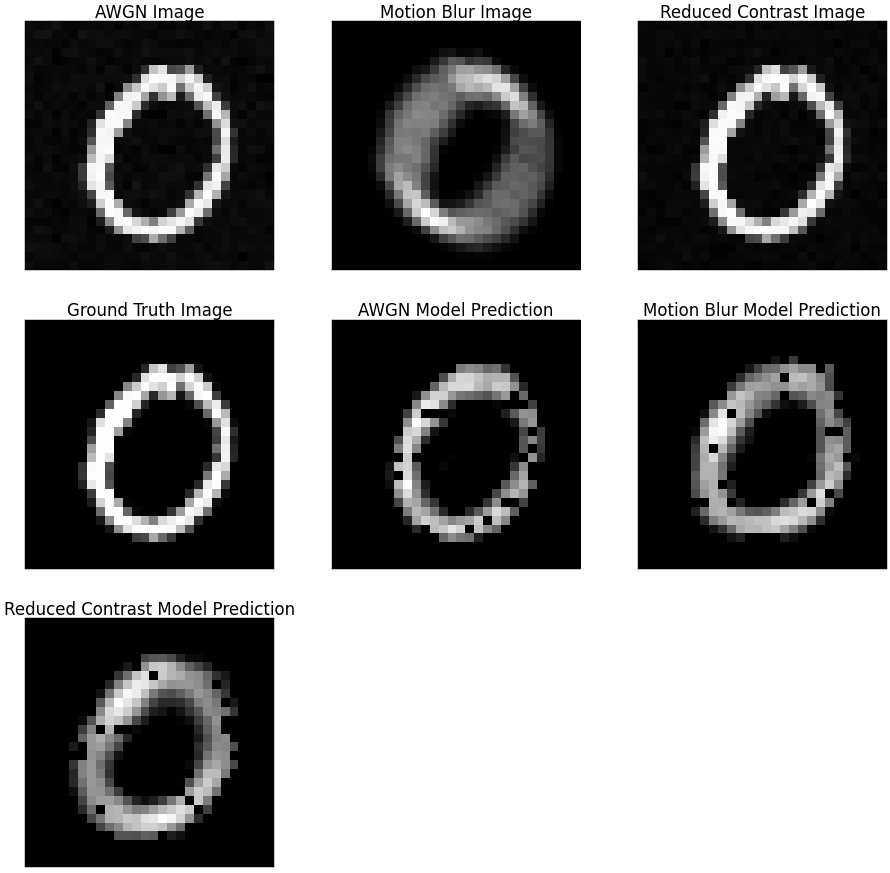

In [ ]:
def plots(idx, awgntest, mbtest, rctest, groundtruth, awgnpredicted, mbpredicted, rcpredicted):
  my_dpi = 40
  fig = plt.figure(figsize=(28, 28), dpi=my_dpi)

  ax1 = fig.add_subplot(3, 3, 1)
  ax1.set_title("AWGN Image", fontsize = 30)
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.imshow(np.reshape(awgntest[idx], (28,28)), cmap='gray')

  ax2 = fig.add_subplot(3, 3, 2)
  ax2.set_title("Motion Blur Image",fontsize = 30)
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.imshow(np.reshape(mbtest[idx], (28,28)), cmap='gray')


  ax3 = fig.add_subplot(3, 3, 3)
  ax3.set_title("Reduced Contrast Image",fontsize = 30)
  ax3.set_xticks([])
  ax3.set_yticks([])
  ax3.imshow(np.reshape(rctest[idx], (28,28)), cmap='gray')

  ax4 = fig.add_subplot(3, 3, 4)
  ax4.set_title("Ground Truth Image",fontsize = 30)
  ax4.set_xticks([])
  ax4.set_yticks([])
  ax4.imshow(np.reshape(groundtruth[idx], (28,28)), cmap='gray')

  ax5 = fig.add_subplot(3, 3, 5)
  ax5.set_title("AWGN Model Prediction",fontsize = 30)
  ax5.set_xticks([])
  ax5.set_yticks([])
  ax5.imshow(np.reshape(awgnpredicted[idx], (28,28)), cmap='gray')

  ax6 = fig.add_subplot(3, 3, 6)
  ax6.set_title("Motion Blur Model Prediction",fontsize = 30)
  ax6.set_xticks([])
  ax6.set_yticks([])
  ax6.imshow(np.reshape(mbpredicted[idx], (28,28)), cmap='gray')

  ax7 = fig.add_subplot(3, 3, 7)
  ax7.set_title("Reduced Contrast Model Prediction",fontsize = 30)
  ax7.set_xticks([])
  ax7.set_yticks([])
  ax7.imshow(np.reshape(rcpredicted[idx], (28,28)), cmap='gray')



  savepath = "/content/drive/MyDrive/MNIST/Models/modifiedimagesplot" + str(idx) + ".jpg"

  fig.savefig(savepath, dpi=40, bbox_inches='tight')

idx = 101
plots(idx, awgntest, mbtest, rctest, gt, awgnoutput, mboutput, rcoutput)

#Image Model

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2, padding=2)  #28-16
        # self.conv2 = nn.Conv2d(16, 32, 7)
        self.conv2 = nn.Conv2d(16, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 256, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(256, 64, 2, stride=2)   #4-8
        self.t_conv2 = nn.ConvTranspose2d(64, 16, 2, stride=2)  #8-16
        self.t_conv3 = nn.ConvTranspose2d(16, 1, 2, stride=2, padding=2) #16-28
        # self.t_conv4 = nn.ConvTranspose2d(16, 1, 7)  


    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.conv2(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = F.relu(self.conv3(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        # print()
        # x = F.relu(self.conv4(x))
        # x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        # print(x.shape)
        x = F.relu(self.t_conv2(x))
        # print(x.shape)
        x = F.relu(self.t_conv3(x))
        # print(x.shape)
        # x = F.relu(self.t_conv4(x))
              
        return x

In [ ]:
conv = ConvAutoencoder()
a = torch.rand(1,1,28,28)
output = conv(a)
print("output", output.shape)

output torch.Size([1, 1, 28, 28])


In [ ]:
# awgnmodel = ConvAutoencoder()
motionblurmodel = ConvAutoencoder()
# reducedcontrastmodel = ConvAutoencoder()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(motionblurmodel.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

num_epochs = 20
dropout = 0.3

In [ ]:
awgnpath = "/content/drive/MyDrive/MNIST/Clean/awgn_train.npy"
motionblurpath = "/content/drive/MyDrive/MNIST/Clean/motion_blur_train.npy"
reducedcontrastpath = "/content/drive/MyDrive/MNIST/Clean/reduced_contrast.npy"
groundtruthpath = "/content/drive/MyDrive/MNIST/Clean/train-images.idx3-ubyte"

In [ ]:
noiseinputpath = motionblurpath

In [ ]:
groundtruthimages = idx2numpy.convert_from_file(groundtruthpath)
noiseinputimages = np.load(noiseinputpath)
print(groundtruthimages.shape, noiseinputimages.shape)

(60000, 28, 28) (60000, 28, 28)


In [ ]:
batch_size = 64 #main control of batch size is here

##Training

In [ ]:
#training loop
motionblurmodel.train()

for epoch in tqdm(range(num_epochs)):
    cumulative_loss = 0.0
    epoch_loss = 0.0    
    batchstart = 0
    batchend = batchstart + batch_size
    numbatches = 0
    for b in range(int(60000/batch_size)+1):              #60000/64 = 938
        groundtruth = torch.from_numpy(groundtruthimages[batchstart:batchend, :, :].astype(np.float32)).unsqueeze(1)  #(32,28, 28)
        inputs = torch.from_numpy(noiseinputimages[batchstart:batchend, :, :].astype(np.float32)).unsqueeze(1)

        model_output = motionblurmodel(inputs)
        loss = criterion(model_output, groundtruth)
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
        if numbatches%100 == 0 :     
            print (numbatches, end=' ')
            print('Loss: ' , cumulative_loss)
            print('-----------------------------------')
            with open('/content/drive/MyDrive/MNIST/Models/motionblurimages', 'at') as file :       
                now = datetime.datetime.now()
                current_time = now.strftime("%H:%M:%S")
                file.write("Epoch: {}, Batch: {}, Loss: {}, Time: {}\n".format(epoch, loss.item(), cumulative_loss, current_time))    
        numbatches += 1
        batchstart = batchend
        batchend = batchstart + batch_size
        # gc.collect()
    
    if epoch%1 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': motionblurmodel.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 100
            }, '/content/drive/MyDrive/MNIST/Models/motionblurimages.pt')

  0%|          | 0/20 [00:00<?, ?it/s]

0 Loss:  6965.65576171875
-----------------------------------
100 Loss:  741242.708984375
-----------------------------------
200 Loss:  1467348.2373046875
-----------------------------------
300 Loss:  2181094.501953125
-----------------------------------
400 Loss:  2916817.5805664062
-----------------------------------
500 Loss:  3602297.6547851562
-----------------------------------
600 Loss:  4317302.57421875
-----------------------------------
700 Loss:  5012884.3994140625
-----------------------------------
800 Loss:  5713210.867675781
-----------------------------------
900 Loss:  6405595.951660156
-----------------------------------


  5%|▌         | 1/20 [01:38<31:05, 98.19s/it]

0 Loss:  6784.0380859375
-----------------------------------
100 Loss:  719710.0009765625
-----------------------------------
200 Loss:  1426388.0146484375
-----------------------------------
300 Loss:  2118312.509765625
-----------------------------------
400 Loss:  2844602.0776367188
-----------------------------------
500 Loss:  3527796.35546875
-----------------------------------
600 Loss:  4236084.115722656
-----------------------------------
700 Loss:  4929082.58203125
-----------------------------------
800 Loss:  5627358.8076171875
-----------------------------------
900 Loss:  6317331.392578125
-----------------------------------


 10%|█         | 2/20 [03:16<29:27, 98.21s/it]

0 Loss:  6779.30029296875
-----------------------------------
100 Loss:  720322.3813476562
-----------------------------------
200 Loss:  1426955.2001953125
-----------------------------------
300 Loss:  2119108.8256835938
-----------------------------------
400 Loss:  2846040.9345703125
-----------------------------------
500 Loss:  3529748.0302734375
-----------------------------------
600 Loss:  4237668.589355469
-----------------------------------
700 Loss:  4931059.034667969
-----------------------------------
800 Loss:  5630630.357910156
-----------------------------------
900 Loss:  6320950.158203125
-----------------------------------


 15%|█▌        | 3/20 [04:54<27:48, 98.13s/it]

0 Loss:  6774.27978515625
-----------------------------------
100 Loss:  719482.5458984375
-----------------------------------
200 Loss:  1426846.767578125
-----------------------------------
300 Loss:  2120233.2954101562
-----------------------------------
400 Loss:  2846580.455078125
-----------------------------------
500 Loss:  3529436.0180664062
-----------------------------------
600 Loss:  4238224.235839844
-----------------------------------
700 Loss:  4932300.986328125
-----------------------------------
800 Loss:  5631930.26171875
-----------------------------------
900 Loss:  6322257.02734375
-----------------------------------


 20%|██        | 4/20 [06:31<26:07, 97.98s/it]

0 Loss:  6775.24951171875
-----------------------------------
100 Loss:  719541.4301757812
-----------------------------------
200 Loss:  1426227.3383789062
-----------------------------------
300 Loss:  2119280.0048828125
-----------------------------------
400 Loss:  2846194.3159179688
-----------------------------------


KeyboardInterrupt: ignored